In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import clip
from PIL import Image
import csv

In [3]:
# set device and load models
device = "cuda" if torch.cuda.is_available() else "mps"

In [31]:
import argparse
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import os
import numpy as np

def rate(img_path):
    """
    Returns: Scores, mean, std
    """
    # Number of classes in the dataset
    num_classes = 10

    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Softmax(1)
    )

    # Weight Path
    weight_path = 'weights/dense121_all.pt'

    # Load weights
    assert os.path.exists(weight_path)
    model_ft.load_state_dict(torch.load(weight_path,
                                        map_location=torch.device('mps'))
                             )

    model_ft.eval()
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    img = transform(img)

    with torch.no_grad():
        scores = model_ft(img.view(1,3,224,224))
        weighted_votes = torch.arange(10, dtype=torch.float) + 1
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1,1)), 2)).sum(dim=1))
    return scores.view(-1).numpy(), mean.item(), std.item()

In [32]:
data_folder= 'data'
output_csv = "nima_score.csv"

In [33]:
# Function to process all images and collect scores
def process_images():
    # Prepare to write CSV
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Prompt", "Image", "Score"])
        # Iterate through each model folder
        for model_folder in os.listdir(data_folder):

            model_path = os.path.join(data_folder, model_folder)
            if os.path.isdir(model_path):
                
                # Iterate through each prompt folder inside the model folder
                for prompt_folder in os.listdir(model_path):
                    prompt_path = os.path.join(model_path, prompt_folder)
                    if os.path.isdir(prompt_path):
                        
                        # Iterate through each image in the prompt folder
                        for image_name in os.listdir(prompt_path):
                            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                                image_path = os.path.join(prompt_path, image_name)
                                
                                # Run the iqa function and get the score
                                try:
                                    _, mean, _ = rate(image_path)
                                except Exception as e:
                                    print(f"Error processing {image_path}: {e}")
                                    continue
                                # Write the result to CSV
                                writer.writerow([model_folder, prompt_folder, image_name, mean])
                                print(f"Processed {image_name} in {model_folder}/{prompt_folder} with score {mean:.2f}")
                            else:
                                print(f"Skipping non-image file {image_name}")
                    else:
                        print(f"Skipping non-directory file {prompt_folder}")
            else:
                print(f"Skipping non-directory file {model_folder}")


In [34]:
process_images()

Skipping non-directory file .DS_Store


/opt/anaconda3/envs/NN/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/NN/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/dv/_l_gwqk95zdggctvnm04j3780000gn/T/ipykernel_48581/2059723027.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://git

Processed WechatIMG75.jpg in stability_ai/prompt_2 with score 5.18
Processed WechatIMG74.jpg in stability_ai/prompt_2 with score 5.80
Processed WechatIMG73.jpg in stability_ai/prompt_2 with score 4.74
Processed WechatIMG72.jpg in stability_ai/prompt_2 with score 5.95
Processed WechatIMG79.jpg in stability_ai/prompt_3 with score 4.15
Processed WechatIMG78.jpg in stability_ai/prompt_3 with score 4.67
Processed WechatIMG76.jpg in stability_ai/prompt_3 with score 4.76
Processed WechatIMG77.jpg in stability_ai/prompt_3 with score 4.73
Processed WechatIMG83.jpg in stability_ai/prompt_4 with score 5.20
Processed WechatIMG82.jpg in stability_ai/prompt_4 with score 5.10
Processed WechatIMG80.jpg in stability_ai/prompt_4 with score 3.73
Processed WechatIMG81.jpg in stability_ai/prompt_4 with score 5.30
Processed WechatIMG68.jpg in stability_ai/prompt_1 with score 4.55
Processed WechatIMG69.jpg in stability_ai/prompt_1 with score 4.66
Processed WechatIMG70.jpg in stability_ai/prompt_1 with score 

In [35]:
# get the data from the csv file
df = pd.read_csv('nima_score.csv')
df.head()

,Model,Prompt,Image,Score
0,stability_ai,prompt_2,WechatIMG75.jpg,5.180278
1,stability_ai,prompt_2,WechatIMG74.jpg,5.801181
2,stability_ai,prompt_2,WechatIMG73.jpg,4.739619
3,stability_ai,prompt_2,WechatIMG72.jpg,5.946359
4,stability_ai,prompt_3,WechatIMG79.jpg,4.149482


In [36]:
# group the data by model
df_grouped = df.groupby('Model')['Score'].mean().sort_values(ascending=False)
df_grouped


Model
microsoft       5.977090
meta            5.564709
tiangong        5.561259
midjourney      5.536373
Baidu           5.497360
akool           5.294021
openai          5.069186
stability_ai    4.947241
flux            4.934426
doubao          4.848987
google          4.704877
tongyi          4.482365
Name: Score, dtype: float64

In [26]:
df_grouped = df.groupby('Prompt')['Score'].mean().sort_values(ascending=False)
df_grouped

Prompt
prompt_2    5.215366
prompt_4    5.165236
prompt_3    5.151540
prompt_1    5.142998
Name: Score, dtype: float64

In [27]:
import scipy.stats as stats

# Performing ANOVA to compare the means of scores across different models
anova_model = stats.f_oneway(*[group['Score'].values for name, group in df.groupby('Model')])

# Performing ANOVA to compare the means of scores across different prompts
anova_prompt = stats.f_oneway(*[group['Score'].values for name, group in df.groupby('Prompt')])

# Display the ANOVA results
anova_model, anova_prompt

(F_onewayResult(statistic=11.284939825868724, pvalue=1.3525188877867826e-14),
 F_onewayResult(statistic=0.1023290152009233, pvalue=0.9585923263870029))

In [28]:
df_grouped = df.groupby('Model')['Score'].var().sort_values(ascending=True)
df_grouped

Model
google          0.079850
flux            0.147913
tongyi          0.228287
meta            0.240310
midjourney      0.251194
openai          0.265709
microsoft       0.268639
doubao          0.318360
akool           0.343729
stability_ai    0.437424
Baidu           0.493272
Name: Score, dtype: float64

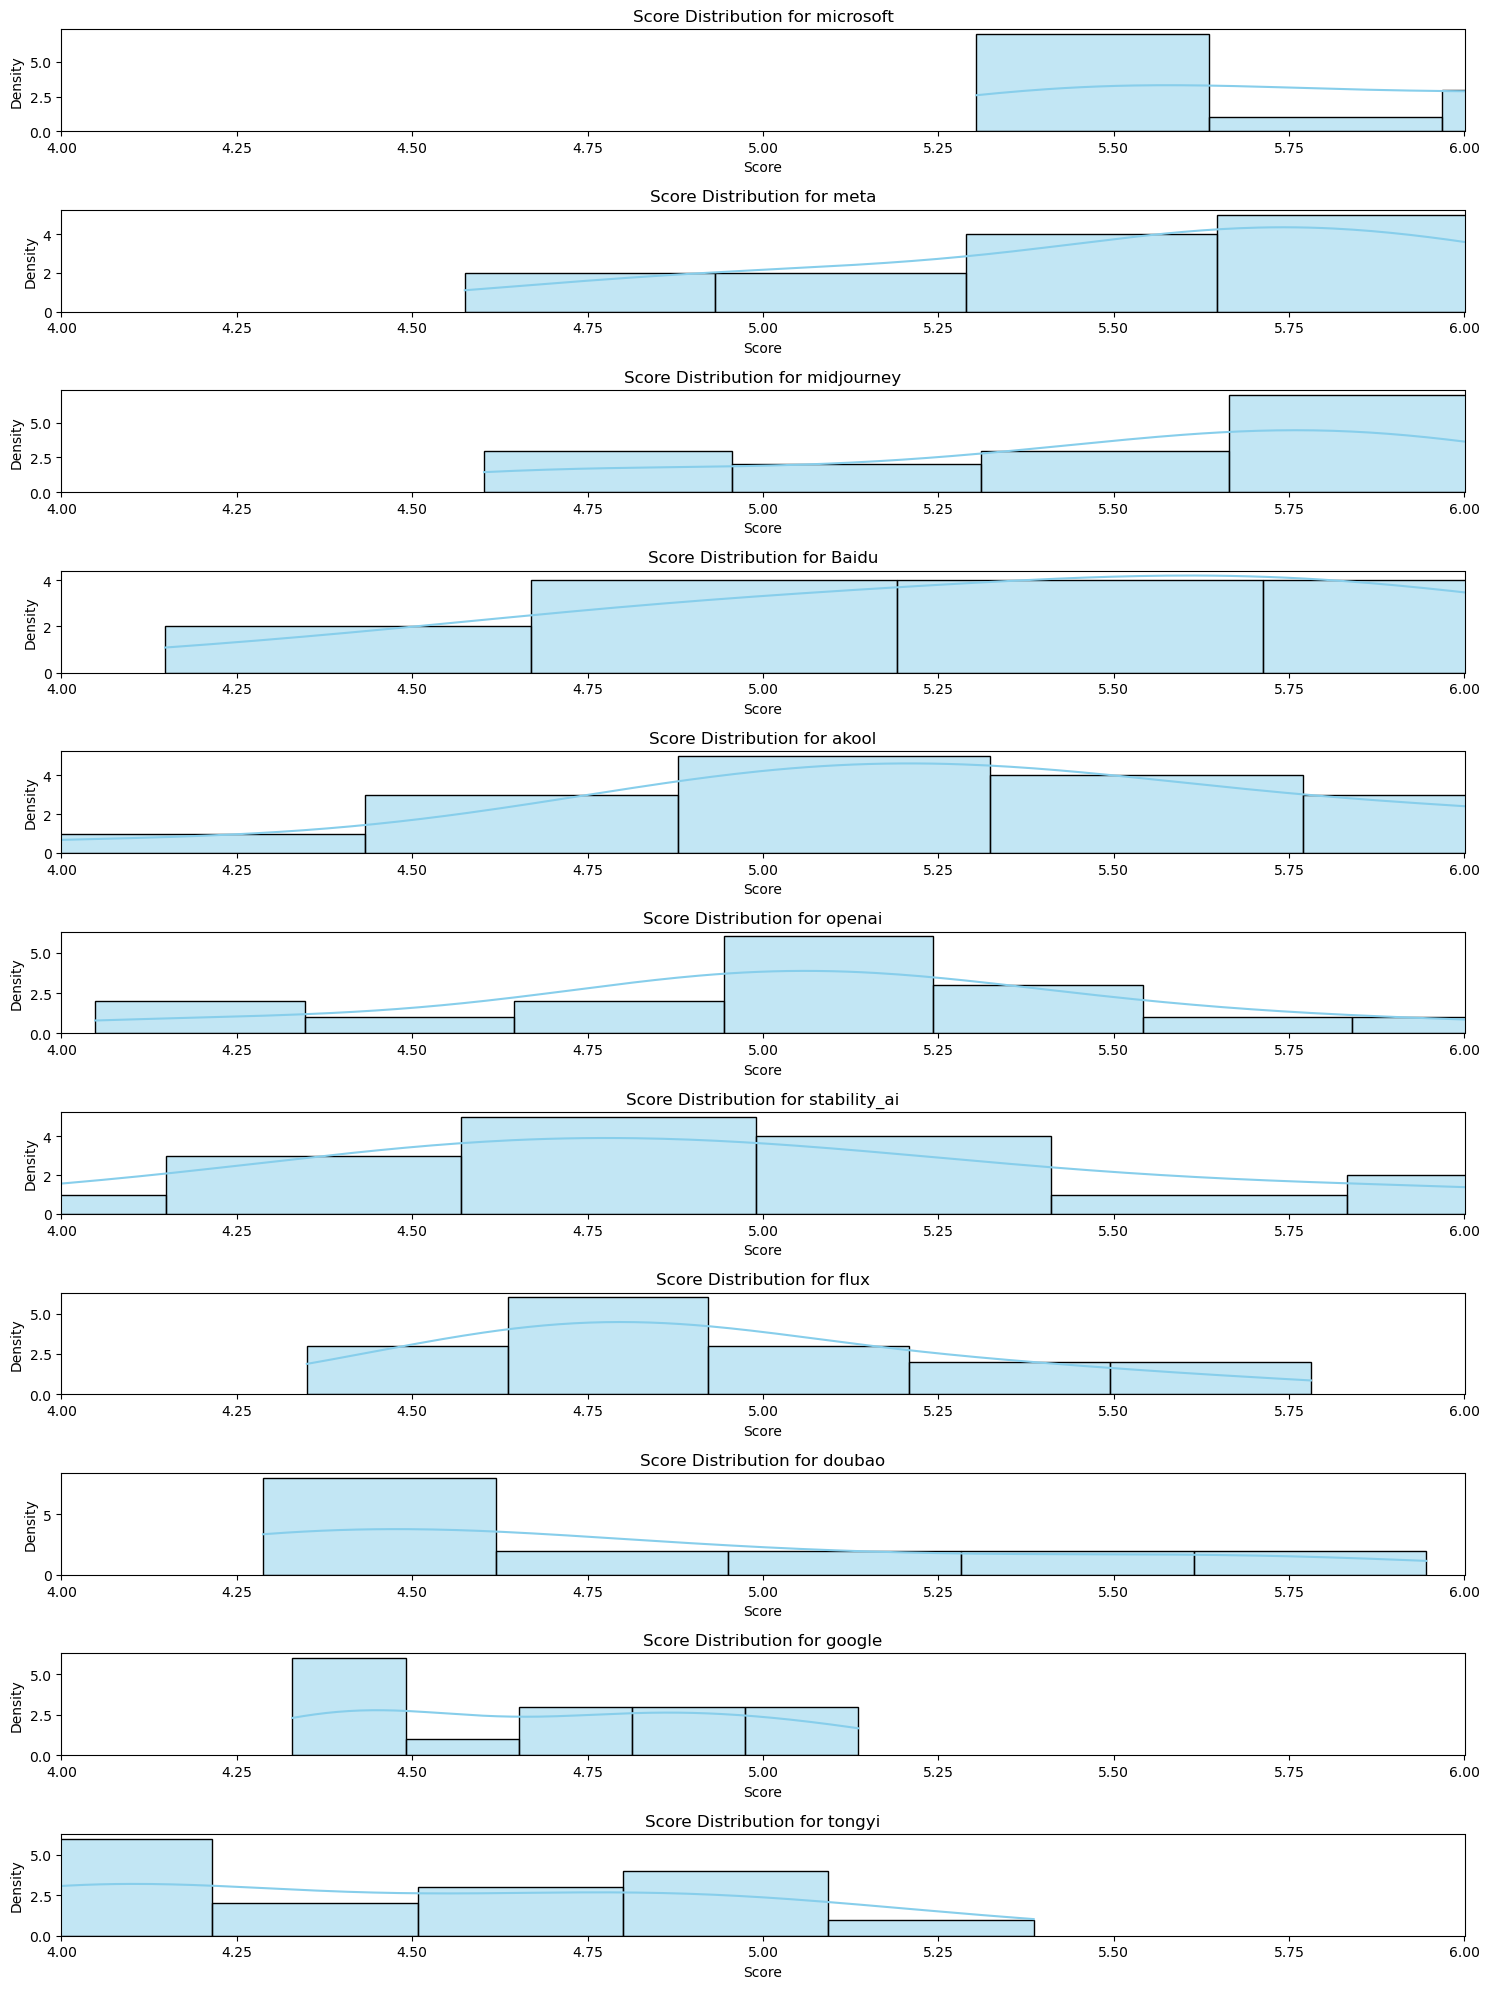

In [30]:
import seaborn as sns
# Plotting individual distributions for each model
models = df['Model'].unique()

# Setting up the figure for multiple subplots
plt.figure(figsize=(15, 20))
# reorder models by the mean score
models = df.groupby('Model')['Score'].mean().sort_values(ascending=False).index
# Loop through each model and plot its distribution separately
for i, model in enumerate(models, 1):
    plt.subplot(len(models), 1, i)
    sns.histplot(df[df['Model'] == model]['Score'], kde=True, color='skyblue')
    plt.title(f'Score Distribution for {model}')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.xlim(4, 6)  # Setting a consistent x-axis range across all plots

plt.tight_layout()
plt.show()